Left and right lane


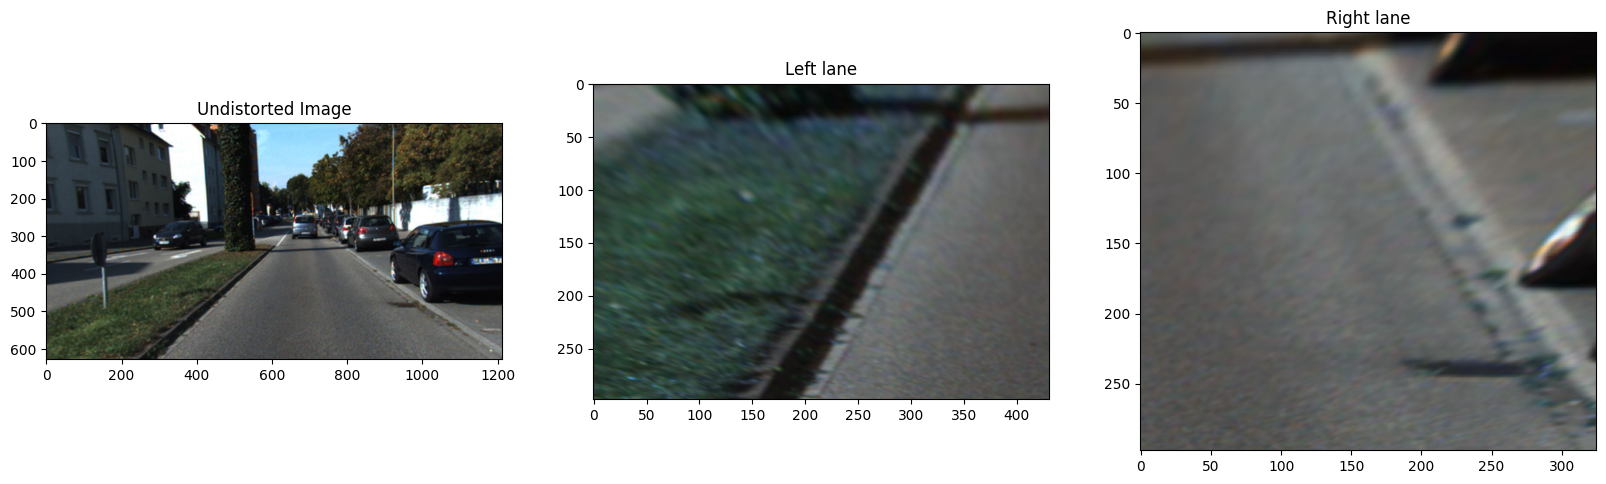

Left and right lane with vertical edge detection


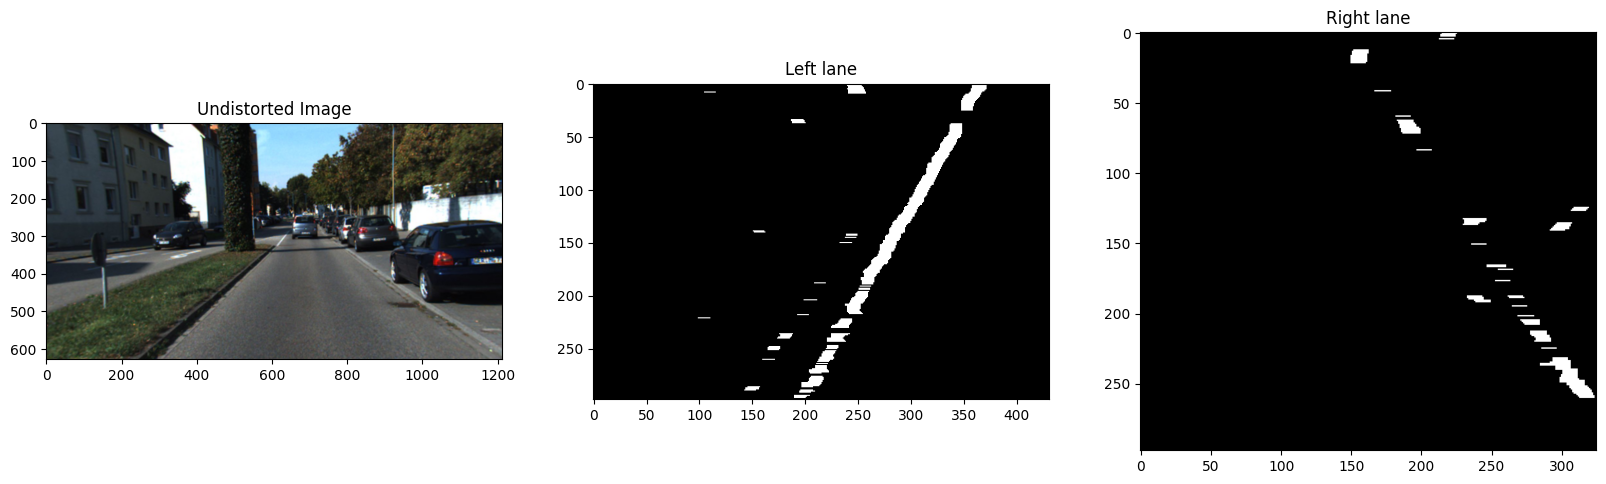

error: OpenCV(4.8.1) /Users/xperience/GHA-OpenCV-Python/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::(anonymous namespace)::CvtHelper<cv::impl::(anonymous namespace)::Set<3, 4, -1>, cv::impl::(anonymous namespace)::Set<1, -1, -1>, cv::impl::(anonymous namespace)::Set<0, 2, 5>, cv::impl::(anonymous namespace)::NONE>::CvtHelper(cv::InputArray, cv::OutputArray, int) [VScn = cv::impl::(anonymous namespace)::Set<3, 4, -1>, VDcn = cv::impl::(anonymous namespace)::Set<1, -1, -1>, VDepth = cv::impl::(anonymous namespace)::Set<0, 2, 5>, sizePolicy = cv::impl::(anonymous namespace)::NONE]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [26]:
import time
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import concurrent.futures
import glob


class LaneDetection:
    def __init__(self):
        self.calibration_data = np.load('calibration.npz')
        self.mtx = self.calibration_data['mtx']
        self.dist = self.calibration_data['dist']
        self.rvecs = self.calibration_data['rvecs']
        self.tvecs = self.calibration_data['tvecs']

    def start(self):
        # get video
        image_paths = glob.glob('./img/KITTI/*.jpg')
        yellow_range = (np.array([20, 100, 20]), np.array([30, 255, 255]))
        white_range = (np.array([0, 0, 200]), np.array([255, 30, 255]))

        img = cv.imread('./img/KITTI/image015.jpg')

        # operations on the frame come here
        frame = self.undistorted_frame(img)
        cropped_frame = self.crop_image(frame)
        transformed_frame = self.transform_perspective(cropped_frame)

        # split the image into left and right side and use multithreading
        transformed_y_half = int(transformed_frame.shape[1] / 2)
        left_frame = transformed_frame[:, :(transformed_y_half - 100)]
        right_frame = transformed_frame[:, (transformed_y_half + 100):(transformed_y_half + 425)]

        with concurrent.futures.ThreadPoolExecutor() as executor:
            # show left and right lane
            print("Left and right lane")
            plt.figure(figsize=(20, 10))
            plt.subplot(1, 3, 1)
            plt.imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
            plt.title("Undistorted Image")
            plt.subplot(1, 3, 2)
            plt.imshow(left_frame, cmap='gray')
            plt.title("Left lane")
            plt.subplot(1, 3, 3)
            plt.imshow(right_frame, cmap='gray')
            plt.title("Right lane")
            plt.show()
            # vertikale Kantenerkennung
            left_future = executor.submit(self.detect_vertical_edges, left_frame)
            right_future = executor.submit(self.detect_vertical_edges, right_frame)

            left_filtered_frame = left_future.result()
            right_filtered_frame = right_future.result()
            # show image
            print("Left and right lane with vertical edge detection")
            plt.figure(figsize=(20, 10))
            plt.subplot(1, 3, 1)
            plt.imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
            plt.title("Undistorted Image")
            plt.subplot(1, 3, 2)
            plt.imshow(left_filtered_frame, cmap='gray')
            plt.title("Left lane")
            plt.subplot(1, 3, 3)
            plt.imshow(right_filtered_frame, cmap='gray')
            plt.title("Right lane")
            plt.show()
            # Thresholding
            left_future = executor.submit(self.threshold_frame, left_filtered_frame)
            right_future = executor.submit(self.threshold_frame, right_filtered_frame)

            left_thresholded_frame = left_future.result()
            right_thresholded_frame = right_future.result()

            # show
            print("Left and right lane with color filter, vertical edge detection and thresholding")
            plt.figure(figsize=(20, 10))
            plt.subplot(1, 3, 1)
            plt.imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
            plt.title("Undistorted Image")
            plt.subplot(1, 3, 2)
            plt.imshow(left_thresholded_frame, cmap='gray')
            plt.title("Left lane")
            plt.subplot(1, 3, 3)
            plt.imshow(right_thresholded_frame, cmap='gray')
            plt.title("Right lane")
            plt.show()

            # Curve fitting
            left_future = executor.submit(self.fit_curve_one_line, left_thresholded_frame)
            right_future = executor.submit(self.fit_curve_one_line, right_thresholded_frame)

            if left_future.result() is None or right_future.result() is None:
                print("No curve found in image {}.".format("img_path"))
            left_x_values, left_y_values = left_future.result()
            right_x_values, right_y_values = right_future.result()

        # draw the lines on the frame
        frame_lanes = self.draw_lines_on_frame(left_x_values, left_y_values, right_x_values, right_y_values,
                                               np.zeros_like(transformed_frame))
        # undo the perspective transformation
        frame_lanes_inv = self.undo_transform_perspective(frame_lanes)
        # fit the curve to the original frame
        frame = self.fit_frame_lanes_to_original_frame(frame_lanes_inv, frame)

        plt.figure(figsize=(20, 10))
        plt.imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
        plt.title("Frame with lanes")
        plt.show()

    def undistorted_frame(self, frame):
        h, w = frame.shape[:2]
        new_camera_mtx, roi = cv.getOptimalNewCameraMatrix(self.mtx, self.dist, (w, h), 1, (w, h))
        undistorted_img = cv.undistort(frame, self.mtx, self.dist, None, new_camera_mtx)

        # crop the image
        x, y, w, h = roi
        return undistorted_img[y:y + h, x:x + w]

    def crop_image(self, frame):
        # zuschneiden des Bildes
        return frame[330:, 150:]

    def transform_perspective(self, frame):
        # get the height and width of the images
        h, w = frame.shape[:2]

        # define the source and destination points for the perspective transformation
        # the tuples are x and y coordinates
        # the tuples are left top, right top, right bottom, left bottom
        src = np.float32([[300, 0], [762, 0], [w, 240], [10, 240]])
        dst = np.float32([[0, 0], [w, 0], [w, h], [0, h]])

        # get the perspective transformation matrix
        M = cv.getPerspectiveTransform(src, dst)
        # warp the image to get a bird view
        warped_frame = cv.warpPerspective(frame, M, (w, h))

        return warped_frame

    def undo_transform_perspective(self, frame):
        h, w = frame.shape[:2]
        # Die Quell- und Ziel-Punkte für die Perspektivtransformation definieren
        src = np.float32([[300, 0], [762, 0], [w, 240], [10, 240]])
        dst = np.float32([[0, 0], [w, 0], [w, h], [0, h]])

        # Die inverse Transformationsmatrix berechnen
        M_inv = cv.getPerspectiveTransform(dst, src)

        # Die Rücktransformation der Vogelperspektive zum Originalbild durchführen
        mask_warp_size_inv = cv.warpPerspective(frame, M_inv, (w, h))

        return mask_warp_size_inv

    def filter_color_range(self, img, lower, upper):
        hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
        mask = cv.inRange(hsv, lower, upper)
        filtered_img = cv.bitwise_and(img, img, mask=mask)
        return filtered_img

    def threshold_frame(self, frame):
        img_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

        # add thresholding
        _, binary_image = cv.threshold(img_gray, 150, 255, cv.THRESH_BINARY)

        return binary_image

    def generate_curve_function(self, params):
        return lambda x: params[0] * x ** 2 + params[1] * x + params[2]

    def opening_frame(self, frame):
        kernel_ver = np.array([[0, 0, 0], [1, 1, 1], [0, 0, 0]], 'uint8')
        opening_frame = cv.morphologyEx(frame, cv.MORPH_OPEN, kernel_ver, iterations=5)
        return opening_frame

    def detect_vertical_edges(self, frame):
        # convert to grayscale
        img_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        # detect vertical edges
        img_sobel_x = cv.Sobel(img_gray, cv.CV_64F, 1, 0, ksize=5)
        # thresholding
        _, img_sobel_x = cv.threshold(img_sobel_x, 250, 255, cv.THRESH_BINARY)
        # reduce noise
        img_sobel_x = self.opening_frame(img_sobel_x)
        
        return img_sobel_x

    def fit_curve_one_line(self, frame_warp):
        """
        :param frame_warp: image in grayscale (cropped, warped and with thresholding)
        :return: x_values, y_values of the curve
        """
        x, y = np.where(frame_warp[:, :] == 255)

        if len(x) == 0:
            return None
        fit = np.polyfit(x, y, 2)

        # Erzeuge eine Liste von x-Werten
        x_values = np.linspace(0, 800, 100)

        # Erzeuge die y-Werte basierend auf der Funktion
        curve_function = self.generate_curve_function(fit)
        y_values = curve_function(x_values)

        return x_values, y_values

    def draw_lines_on_frame(self, f1_x_values, f1_y_values, f2_x_values, f2_y_values, frame_lanes):
        # create image from curve function
        y_offset = int(frame_lanes.shape[1] / 2 + 100)
        for i in range(len(f1_x_values) - 1):
            cv.line(frame_lanes, (int(f1_y_values[i]), int(f1_x_values[i])),
                    (int(f1_y_values[i + 1]), int(f1_x_values[i + 1])), (255, 255, 255), 20)
            cv.line(frame_lanes, (int(f2_y_values[i]) + y_offset, int(f2_x_values[i])),
                    (int(f2_y_values[i + 1]) + y_offset, int(f2_x_values[i + 1])),
                    (255, 255, 255), 20)

        return frame_lanes

    def fit_frame_lanes_to_original_frame(self, frame_lanes, frame):
        h, w = frame_lanes.shape[:2]
        # create mask for lanes in original frame to fit the curve to the original frame
        mask_original_size = np.zeros_like(frame)
        h_o, w_o = frame.shape[:2]
        a = w_o / 2 - w / 2 + 75
        b = w_o / 2 + w / 2 + 75

        mask_original_size[h_o - h:h_o, int(a):int(b)] = frame_lanes

        # Erzeuge ein boolean-Array für die Pixel, die in der Maske gesetzt sind
        mask_bool_pixels = mask_original_size[:, :, 0] == 255

        # Setze die Farbwerte für die Pixel in img_original, wo die Maske gesetzt ist
        frame[mask_bool_pixels] = [0, 0, 255]

        return frame


if __name__ == '__main__':
    lane_detection = LaneDetection()
    lane_detection.start()